### Imports

In [97]:
from __future__ import print_function, division
import itertools
import os
from IPython.core.debugger import set_trace

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.preprocessing import text, sequence
from keras import utils

import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
device

device(type='cuda')

### Create plotting function

In [98]:
plt.style.use('ggplot')

def plot_acc_loss(acc, val_acc, loss, val_loss):
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Define text preprocessing functions

In [99]:
# Applying a first round of text cleaning techniques
import re, string
from bs4 import BeautifulSoup

def clean_text(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    eyes = "[8:=;]"
    nose = "['`\-]?"
    text = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " ", text)

    text = re.sub("/", " / ", text)
    text = re.sub('@(\w+)', '', text)

    text = re.sub('#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}', "<smile>", text)
    text = re.sub('#{eyes}#{nose}p+', "<lolface>", text)
    text = re.sub('#{eyes}#{nose}\(+|\)+#{nose}#{eyes}', "<sadface>", text)
    text = re.sub('#{eyes}#{nose}[\/|l*]', "<neutralface>", text)
    text = re.sub('<3', "<heart>", text)
    # numbers
    text = re.sub('[-+]?[.\d]*[\d]+[:,.\d]*', " ", text)

    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    # text = re.sub('\[.*?\]', '', text)
    # text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation.replace('<', '').replace('>', '')), ' ', text)
    text = re.sub('\n', ' ', text)

    # text = re.sub(r"[^a-zA-Z]", ' ', text)
    text = ''.join(filter(lambda x: x in string.printable, text))
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # text = re.sub('\w*\d\w*', '', text)

    return text


import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


def text_preprocessing(text):
    tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)

    lemmatizer = nltk.stem.WordNetLemmatizer()

    nopunc = clean_text(text)

    tokenized_text = tokenizer.tokenize(nopunc)

    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]

    lemmatized = [lemmatizer.lemmatize(i, j[0].lower()) if j[0].lower() in ['a', 'n', 'v'] else lemmatizer.lemmatize(i)
                  for i, j in pos_tag(remove_stopwords)]

    combined_text = ' '.join(lemmatized)
    return combined_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Read data or preprocessed data if it exists

In [100]:
'''
try:
    train = pd.read_csv('../input/preprocessed_train.csv')
    print('Preprocessed training data shape: ', train.shape)
    test = pd.read_csv('../input/preprocessed_test.csv')
    print('Preprocessed testing data shape: ', test.shape)
    
except:
    train = pd.read_csv('../input/train.csv')
    print('Training data shape: ', train.shape)
    test = pd.read_csv('../input/test.csv')
    print('Testing data shape: ', test.shape)
    
    train['text'] = train['text'].apply(lambda x: text_preprocessing(x))
    test['text'] = test['text'].apply(lambda x: text_preprocessing(x))
    train.to_csv('../input/preprocessed_train.csv')
    test.to_csv('../input/preprocessed_test.csv')

train.drop(["keyword", "location"], axis = 1, inplace=True)
test.drop(["keyword", "location"], axis = 1, inplace=True)
'''

'\ntry:\n    train = pd.read_csv(\'../input/preprocessed_train.csv\')\n    print(\'Preprocessed training data shape: \', train.shape)\n    test = pd.read_csv(\'../input/preprocessed_test.csv\')\n    print(\'Preprocessed testing data shape: \', test.shape)\n    \nexcept:\n    train = pd.read_csv(\'../input/train.csv\')\n    print(\'Training data shape: \', train.shape)\n    test = pd.read_csv(\'../input/test.csv\')\n    print(\'Testing data shape: \', test.shape)\n    \n    train[\'text\'] = train[\'text\'].apply(lambda x: text_preprocessing(x))\n    test[\'text\'] = test[\'text\'].apply(lambda x: text_preprocessing(x))\n    train.to_csv(\'../input/preprocessed_train.csv\')\n    test.to_csv(\'../input/preprocessed_test.csv\')\n\ntrain.drop(["keyword", "location"], axis = 1, inplace=True)\ntest.drop(["keyword", "location"], axis = 1, inplace=True)\n'

In [101]:
train = pd.read_csv('../input/train.csv')
print('Training data shape: ', train.shape)
test = pd.read_csv('../input/test.csv')
print('Testing data shape: ', test.shape)

train['text'] = train['text'].apply(lambda x: text_preprocessing(x))
test['text'] = test['text'].apply(lambda x: text_preprocessing(x))

train.drop(["keyword", "location"], axis = 1, inplace=True)
test.drop(["keyword", "location"], axis = 1, inplace=True)

train.to_csv('../input/preprocessed_train.csv')
test.to_csv('../input/preprocessed_test.csv')

Training data shape:  (7613, 5)
Testing data shape:  (3263, 4)


### Create embedding matrix function

In [102]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

### Retrieve embedding matrix

In [103]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train["text"])
vocab_size = len(tokenizer.word_index) + 1
#print(tokenizer.word_index)
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
        '../input/glove.twitter.27B.50d.txt',
    #'../input/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.18131     0.52524    -0.28472    ... -0.30759999 -0.42807001
   0.68215001]
 [-0.094661    0.13413     0.21436    ...  0.47062001 -0.44501001
   0.13282999]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.41821    -0.76490003  0.49147999 ... -0.48903999  0.33109999
   0.74254   ]
 [-0.48291001 -0.0029234  -1.59609997 ...  0.44295999 -0.29177001
   0.47444001]]


In [104]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8697109342270632

In [105]:
print(embedding_matrix.shape)

(11935, 50)


### Tokenize

In [106]:
print(train.iloc[5680])
print(test.iloc[13])

train["text"] = tokenizer.texts_to_sequences(train["text"].values)
test["text"] = tokenizer.texts_to_sequences(test["text"].values)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(vocab_size)

id                        8105
text      skyrim awaits rescue
target                       0
Name: 5680, dtype: object
id      43
text      
Name: 13, dtype: object
11935


In [107]:
print(type(train.iloc[0].text))

<class 'list'>


In [108]:
test['text'] = test['text'].apply(lambda x: [0] if x == [] else x)
train['text'] = train['text'].apply(lambda x: [0] if x == [] else x)


In [109]:
print(train[train.astype(str)['text'] == '[]'])

Empty DataFrame
Columns: [id, text, target]
Index: []


### Convert word ids to vectors

In [110]:
'''
def tokens_to_averaged_vectors(tokens, embedding_matrix):
    vectors = np.asarray([np.asarray(embedding_matrix[token]) for token in tokens])
    return vectors.mean(axis=0)
'''

'\ndef tokens_to_averaged_vectors(tokens, embedding_matrix):\n    vectors = np.asarray([np.asarray(embedding_matrix[token]) for token in tokens])\n    return vectors.mean(axis=0)\n'

In [111]:
'''
train_text = train["text"].apply(lambda x: tokens_to_averaged_vectors(x, embedding_matrix))
test_text = test["text"].apply(lambda x: tokens_to_averaged_vectors(x, embedding_matrix))
'''

train_text = train["text"]
test_text = test["text"]

### Split training and validation data

In [112]:
from sklearn.model_selection import train_test_split

target = train["target"]
train_data, validation_data, train_target, validation_target = train_test_split(
   train_text, target, test_size=0.2, random_state=1000)
test_data = test_text

In [113]:
validation_target.shape, train_target.shape


((1523,), (6090,))

In [114]:
class Config(object):
    embed_size = 50
    hidden_layers = 4
    hidden_size = 32
    bidirectional = True
    output_size = 2
    max_epochs = 10
    lr = 0.25
    batch_size = 1
    max_sen_len = 20 # Sequence length for RNN
    dropout_keep = 0.8

### Define Model

In [115]:
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace

def create_emb_layer(weights_matrix):
    num_embeddings, embedding_dim = weights_matrix.shape
    #emb_layer = nn.EmbeddingBag(num_embeddings, embedding_dim, sparse=True)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix, freeze=True) 
    
    #if non_trainable:
        #emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class TwitterClassifier(nn.Module):
    def __init__(self, weights_matrix, config):
        super().__init__()
        self.config = config
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix)
       
        self.lstm = nn.LSTM(input_size = embedding_dim,
                            hidden_size = self.config.hidden_size,
                            num_layers = self.config.hidden_layers,
                            dropout = self.config.dropout_keep,
                            bidirectional = self.config.bidirectional)
        
        self.dropout = nn.Dropout(0.8)
        
        # Fully-Connected Layer
        self.linear = nn.Linear(
            self.config.hidden_size * self.config.hidden_layers * (1+self.config.bidirectional),
            self.config.output_size
        )
        
        # The linear layer that maps from hidden state space to tag space
        #self.linear = nn.Linear(embedding_dim, 2)
        #self.init_weights()
        
    def forward(self, textbatch):
        text = textbatch[0]
        embedded = self.embedding(text)
        lstm_out, (h_n,c_n) = self.lstm(embedded.view(len(text), 1, -1))
        final_feature_map = self.dropout(h_n) # shape=(num_layers * num_directions, batch_size, hidden_size)
        
        # Convert input to (batch_size, hidden_size * hidden_layers * num_directions) for linear layer
        final_feature_map = torch.cat([final_feature_map[i,:,:] for i in range(final_feature_map.shape[0])], dim=1)
        #lstm_out, _ = self.lstm(embedded.view(len(text), 1, -1))
        linear = self.linear(final_feature_map)
    
        return linear
   

### Create custom Dataset

In [116]:
# custom dataset
class TwitterDataset(Dataset):
    def __init__(self, texts, labels=None, transforms=None):
        self.X = texts
        if labels is not None:
            self.y = np.asarray(labels)
        else:
            self.y = None
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i]
        data = torch.tensor(data)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
print(train_data.head())
train_data = TwitterDataset(train_data, train_target)
validation_data = TwitterDataset(validation_data, validation_target)
test_data = TwitterDataset(test_data)
print(train_data[0])
print(test_data[0])

6101                              [471, 10670, 1770, 326]
3298    [8339, 603, 2645, 833, 277, 711, 2207, 88, 927...
6817    [297, 127, 252, 103, 127, 1117, 2336, 885, 113...
3801                      [8781, 185, 1866, 558, 3, 2354]
7088    [5267, 1414, 1302, 993, 5268, 1353, 1471, 3643...
Name: text, dtype: object
(tensor([  471, 10670,  1770,   326]), 0)
tensor([ 220, 1616,   51,   18])


### Create model

In [117]:
print(embedding_matrix.shape)

(11935, 50)


In [118]:
torch.manual_seed(42)
model = TwitterClassifier(torch.tensor(embedding_matrix, dtype=torch.float), Config()).to(device)
#model = TwitterClassifier(torch.tensor(embedding_matrix, dtype=torch.float)).to(device)
model


TwitterClassifier(
  (embedding): Embedding(11935, 50)
  (lstm): LSTM(50, 32, num_layers=4, dropout=0.8, bidirectional=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)

In [119]:
def generate_batch(batch):
    label = torch.tensor([entry[1] for entry in batch])
    text = [entry[0] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [120]:
def prec_rec_F1(labels, preds):
    # true positives
    tp = 0
    # false negatives
    fn = 0
    for label, pred in zip(labels, preds):
        if label == 1:
            if pred == 1:
                tp += 1
            else:
                fn += 1
                
    pospreds = sum(preds)
    precision = tp / pospreds
    recall = tp / (fn + tp)
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return (precision, recall, 0.0)
    return (precision, recall, f1)

In [121]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    labels = []
    preds = []
    # dataloaders
    data = DataLoader(sub_train_, shuffle=True)
    for i, (text, cls) in enumerate(data):
        optimizer.zero_grad()
        text, cls = text.to(device), cls.to(device)
        output = model(text)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(1)
        train_acc += (pred == cls).sum().item()
        labels.append(cls.item())
        preds.append(pred.item())

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_), prec_rec_F1(labels, preds)

def validate_func(data_):
    loss = 0
    acc = 0
    labels = []
    preds = []
    data = DataLoader(data_)
    for text, cls in data:
        text, cls = text.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text)
            l = criterion(output, cls)
            loss += l.item()
            pred = output.argmax(1)
            acc += (pred == cls).sum().item()
            labels.append(cls.item())
            preds.append(pred.item())
            
    return loss / len(data_), acc / len(data_), prec_rec_F1(labels, preds)

### Train the model

In [122]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 8
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

sub_train_, sub_valid_ = train_data, validation_data
all_train_loss = []
all_valid_loss = []
all_train_acc = []
all_valid_acc = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, (train_precision, train_recall, train_F1) = train_func(sub_train_)
    valid_loss, valid_acc, (valid_precision, valid_recall, valid_F1) = validate_func(sub_valid_)

    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_valid_loss.append(valid_loss)
    all_valid_acc.append(valid_acc)
    
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\t\tF1 score: {train_F1:.2f} (train)\n\t\tF1 score: {valid_F1:.2f} (valid)')

Epoch: 1  | time in 3 minutes, 3 seconds
		F1 score: 0.63 (train)
		F1 score: 0.76 (valid)
Epoch: 2  | time in 2 minutes, 56 seconds
		F1 score: 0.71 (train)
		F1 score: 0.72 (valid)
Epoch: 3  | time in 3 minutes, 20 seconds
		F1 score: 0.73 (train)
		F1 score: 0.74 (valid)
Epoch: 4  | time in 3 minutes, 33 seconds
		F1 score: 0.74 (train)
		F1 score: 0.75 (valid)
Epoch: 5  | time in 2 minutes, 34 seconds
		F1 score: 0.74 (train)
		F1 score: 0.76 (valid)
Epoch: 6  | time in 2 minutes, 30 seconds
		F1 score: 0.75 (train)
		F1 score: 0.72 (valid)
Epoch: 7  | time in 2 minutes, 23 seconds
		F1 score: 0.75 (train)
		F1 score: 0.74 (valid)
Epoch: 8  | time in 2 minutes, 23 seconds
		F1 score: 0.75 (train)
		F1 score: 0.72 (valid)


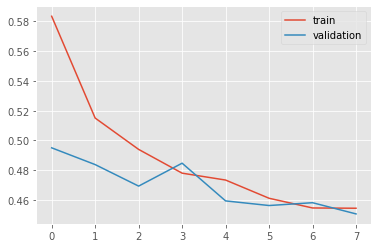

In [123]:
plt.plot(all_train_loss, label='train')
plt.plot(all_valid_loss, label='validation')
plt.legend()

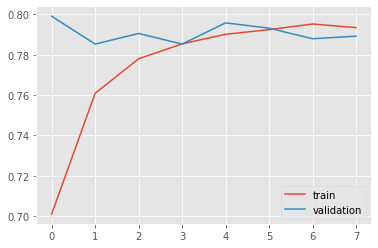

In [124]:
plt.plot(all_train_acc, label='train')
plt.plot(all_valid_acc, label='validation')
plt.legend()

### Predict

In [125]:
def predict_func(test_data_):
    predictions = []
    data = DataLoader(test_data_)
    for text in data:
        text = text.to(device)
        with torch.no_grad():
            output = model(text)
            predictions.append(output.argmax(1))

    return predictions

predictions = predict_func(test_data)
print(len(predictions))


3263


### Create submission

In [126]:
print(predictions[0].item())

1


In [127]:
def submission(submission_file_path,submission_data):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = [tensor.cpu().numpy()[0] for tensor in submission_data]
    print(sample_submission["target"])
    sample_submission.to_csv("submission.csv", index=False)

In [128]:
submission_file_path = "../input/sample_submission.csv"
submission(submission_file_path,predictions)

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    0
Name: target, Length: 3263, dtype: int64
